In [1]:
import os
from tqdm import tqdm, trange
import pandas as pd

from statistics_tests import perform_ks, estimate_power_with_data
from seed_data_mappers import model_dict, file_to_directory, model_dirs
from dataframe_helpers import update_dataframe, extract_prefix, truncate_error
from scoring import normalize_resources, scaled_resources, transformer_embeddings, quantized_vectors, make_anomaly_scores

In [2]:
directory = './data/resource_results'
corpora_dir = './corpora'
cleaned_dir = "./data/cleaned_resources"

max_errors = 35 # Amount of error messages considered too many
n_simulations=1000 # Number of Monte-Carlo simulations 
ks_a = 0.05 # Cutoff for null hypothesis
k = 100 # Number of distances for anomaly detection
limit_atheris = True # Take a smaller amount of Atheris samples
atheris_entries = 10_000 # The number of atheris to take if limi_atheris

number_of_samples = 100 # Final number of samples to produce

In [3]:
# Score coefficients
alpha_embed = 1 # Input embedding anomaly weight
beta_scaled = 1 # Scaled resource values weight
gamma_anom = 1 # Quantized resource anomaly weight


scaling = {
       'Output Size (B)': 1,
       'Output Entropy (bits per symbol)' : 1,
       'Top Function Calls': 1, 
       'Peak Memory (B)': 1,
       'Final Memory (B)': 1,
       'CPU (ms)': 1, 
       'SLOC': 1,
       'Instructions': 1, 
}

In [6]:
prefixes = extract_prefix(directory)
unique = set(prefixes)
print(len(unique))
unique = ["xlrd_open_workbook"]

50


In [7]:
dfs = {}
# Something is wrong with phonenumbers_parse, ftplib_FTP, exrex_getone
for x in tqdm(unique):
    df_concat = []
    for v in model_dict.values():
        file_path = f"{directory}/{x}_{v}.parquet"
        if not os.path.exists(file_path):
            print(f"!!!Missing!!! {file_path}")
            continue
        else: 
            dft = pd.read_parquet(file_path)
            # Clean up of top function calls, which sometimes gets a /
            dft["Top Function Calls"] = dft["Top Function Calls"].str.split('/').str[0]
            dft["Top Function Calls"] = pd.to_numeric(dft["Top Function Calls"])
            df_concat.append( dft )
    current_df = pd.concat(df_concat, axis=0)
    current_df.reset_index(drop=True, inplace=True)
    if len(current_df["Error"].unique()) > max_errors: 
        current_df = truncate_error(current_df, x)
        
        len_error = len(current_df["Error"].unique())
        print(f"  {x} max error: {len_error}")
        # Still didn't reduce enough
        assert len_error <= max_errors, f"{x}: {len_error} Unique Errors"
    current_df = normalize_resources(current_df)
    print(f"Current DF: {len(current_df)}")
    current_df = update_dataframe(current_df) 
    # Remove any checkpoints that snuck in
    current_df = current_df[~current_df['Sample'].str.contains('ipynb_checkpoints', na=False)]

    current_df.to_parquet(f"{cleaned_dir}/{x}.parquet")
    dfs[x] = current_df

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

  xlrd_open_workbook max error: 7
Current DF: 110122


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]

Error reading file ./corpora/xlrd.open_workbook/gpt-3.5-turbo/1.0/merge_corpus/.ipynb_checkpoints: [Errno 2] No such file or directory: './corpora/xlrd.open_workbook/gpt-3.5-turbo/1.0/merge_corpus/.ipynb_checkpoints'
100011
20924


In [6]:
cur_test = list(dfs.keys())[-1]
cur_test

'simplejson_loads'

In [7]:
dfs[cur_test]["Corpus Location"].unique()

array(['./corpora/simplejson.loads/random_data',
       './corpora/simplejson.loads/atheris_output',
       './corpora/simplejson.loads/gpt-3.5-turbo/1.0/merge_corpus',
       './corpora/simplejson.loads/gpt-4-turbo-preview/1.0/merge_corpus',
       './corpora/simplejson.loads/claude-3-opus-20240229/1.0/merge_corpus',
       './corpora/simplejson.loads/claude-instant-1.2/1.0/merge_corpus',
       './corpora/simplejson.loads/gemini-1.0-pro/1.0/merge_corpus'],
      dtype=object)

In [7]:
df = dfs[cur_test]
df = df.sample(frac=1).reset_index(drop=True)

if limit_atheris:
    atheris_df = df[df['Corpus'] == 'Atheris']
    other_df = df[df['Corpus'] != 'Atheris']
    atheris_df = atheris_df.sample(n=atheris_entries, random_state=1) 
    df = pd.concat([atheris_df, other_df], ignore_index=True)

In [8]:
# Apply Scoring

if alpha_embed > 0: # Skip the embeddings if not part of score
    df = transformer_embeddings(df)
    df = make_anomaly_scores(df, "Embeddings", k)
else:
    df["Embeddings Distances"] = 0

if gamma_anom > 0: # Skip resource anomalies if not part of score
    df = quantized_vectors(df)
    df = make_anomaly_scores(df, "Resources", k)
else:
    df["Resources Distances"] = 0
    
# No need to skip scaling, it produces minimal overhead
df = scaled_resources(df)

print(df["Embeddings Distances"].max())
print(df["Scaled Resources"].max())
print(df["Resources Distances"].max())

Loading Model


/home/g/miniconda3/envs/amira/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Running Batches
0.6635343
0.5986646374936032
0.0032125711


In [9]:

summed_coefficients = alpha_embed + beta_scaled + gamma_anom
# Requires the above be run first
df['Score'] = ( alpha_embed * df['Embeddings Distances'] + 
                beta_scaled * df['Scaled Resources'] + 
                gamma_anom * df['Resources Distances']) / summed_coefficients
print(df["Score"].max())

0.36140387733411483


In [10]:
field = "Resources Distances" #"Scaled Resources" #"Instructions" "Peak Memory (B)"
df['Corpus'].unique()

array(['Atheris', 'Random', 'Claude-Opus', 'Gemini-1.0', 'GPT-4',
       'Claude-Instant', 'GPT-3'], dtype=object)

In [11]:
corpus_comparisons = {}

for c1 in tqdm(model_dirs.keys()):
    corpus_comparisons[c1] = {}
    for c2 in model_dirs.keys():
        corpus_comparisons[c1][c2] = {}
        # print(f"{c1} - {c2}")
        data1 = df[df['Corpus'] == c1][field]
        data2 = df[df['Corpus'] == c2][field]
        initial_statistic, initial_p_value, hypothesis = perform_ks(data1, data2, ks_a)
        power = estimate_power_with_data(data1, data2, n_simulations, ks_a)
        # print(f"Estimated power of the KS test: {power}")
        corpus_comparisons[c1][c2]["KS"] = initial_statistic
        corpus_comparisons[c1][c2]["p-value"] = initial_p_value
        corpus_comparisons[c1][c2]["hypothesis"] = hypothesis
        corpus_comparisons[c1][c2]["power"] = power

 14%|████████████▏                                                                        | 1/7 [00:11<01:10, 11.68s/it]/home/g/ruff/statistics_tests.py:18: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  statistic, p_value = ks_2samp(sample1, sample2)
100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:36<00:00,  5.18s/it]


In [12]:
top_samples = df.nlargest(number_of_samples, 'Score')

In [13]:
counts = { "Atheris": 0,
           "Random": 0,
           "LLM": 0,
         }
count = 0
for index, row in top_samples.iterrows():
    count += 1
    corpus = row['Corpus']
    sample = row['Sample']
    score = row['Score']
    
    c_dir = file_to_directory[f"file_{cur_test}.py"]
    sample_dir = f"{corpora_dir}/{c_dir}/{model_dirs[corpus]}/{sample}"
    
    if corpus != "Atheris" and corpus != "Random":
        corpus = "LLM"
    counts[corpus] += 1
    #print(sample_dir)
print(counts)

{'Atheris': 63, 'Random': 25, 'LLM': 12}


In [14]:
results_dictionary = {
 "coefficients": { "alpha_embed": alpha_embed, "beta_scaled": beta_scaled, "gamma_anom": gamma_anom},
 "scaling": scaling,
 "counts": counts,
 "comparisons": corpus_comparisons
}

In [15]:
#df.to_parquet(f"./score_results/{cur_test}.parquet")

# Visualization

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

/home/g/miniconda3/envs/amira/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/g/miniconda3/envs/amira/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/g/miniconda3/envs/amira/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/g/miniconda3/envs/amira/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

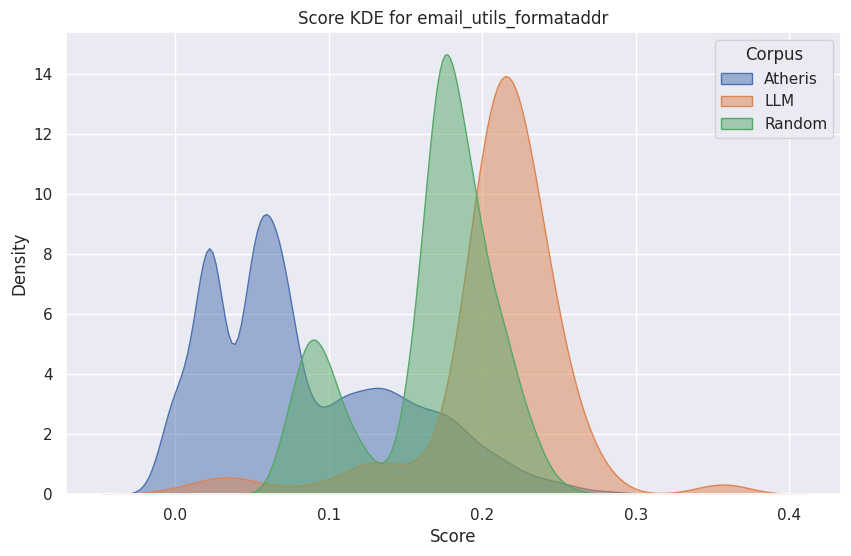

In [17]:
sns.set(style="darkgrid")

col_kde = "Score" #"Embeddings Distances" "Scaled Resources" "Score" "Resources Distances" "Embeddings Distances"

df['Plot Corpus'] = df['Corpus'].apply(lambda x: x if x in ['Atheris', 'Random'] else 'LLM')

# Create a single plot with KDEs for each unique corpus
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
for name, group in df.groupby('Plot Corpus'):
    sns.kdeplot(data=group[col_kde], fill=True, common_norm=False, alpha=0.5, label=f'{name}')

plt.title(f'{col_kde} KDE for {cur_test}')
plt.xlabel(col_kde)
plt.ylabel('Density')
plt.legend(title='Corpus')
#plt.xlim([-0.2, 0.35])
plt.savefig(f'images/KDE_{col_kde}_{cur_test}.png', bbox_inches='tight')
plt.show()